In [6]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Путь к папке с атаками
base_path = "./attacks/"

combined_path = "./combined/"
os.makedirs(combined_path, exist_ok=True)

attack_folders = os.listdir(base_path)
attack_labels = {attack: idx + 1 for idx, attack in enumerate(attack_folders)}
attack_labels

{'brute-http': 1,
 'brute-ftp': 2,
 'inf-usb': 3,
 'xss': 4,
 'brute-ssh': 5,
 'inf-dropbox': 6,
 'sql-inj': 7,
 'botnet-ares': 8}

In [8]:
# Найти все уникальные размеры выборок
packet_intervals = set()

for attack in attack_folders:
    common_path = os.path.join(base_path, attack, "csvs")
    for traffic_type in ["normal", "attack"]:
        traffic_path = os.path.join(common_path, traffic_type)
        for filename in os.listdir(traffic_path):
            # Извлечение размера выборки из имени файла с помощью регулярного выражения
            match = re.search(r"_(\d+)_\d+_", filename)
            if match:
                packet_intervals.add(int(match.group(1)))

# Сортируем размеры выборок
packet_intervals = sorted(packet_intervals)
print("Найденные размеры выборок пакетов:", packet_intervals)

Найденные размеры выборок пакетов: [10, 50, 100, 250, 500, 750, 1000, 5000, 10000]


In [9]:
# Объединение данных для каждого размера выборки
for packet_size in packet_intervals:
    combined_df = pd.DataFrame()

    for attack in attack_folders:
        attack_path = os.path.join(base_path, attack, "csvs")

        # Определяем единственный файл нормального и атакующего трафика для текущего размера выборки
        normal_file = next(
            (
                f
                for f in os.listdir(os.path.join(attack_path, "normal"))
                if f"_{packet_size}_0_" in f
            ),
            None,
        )
        attack_file = next(
            (
                f
                for f in os.listdir(os.path.join(attack_path, "attack"))
                if f"_{packet_size}_1_" in f
            ),
            None,
        )

        if normal_file and attack_file:
            # Чтение файла с нормальным трафиком и добавление метки
            normal_df = pd.read_csv(os.path.join(attack_path, "normal", normal_file))
            normal_df["Label"] = 0  # Метка для нормального трафика
            combined_df = pd.concat([combined_df, normal_df], ignore_index=True)

            # Чтение файла с атакующим трафиком и добавление метки
            attack_df = pd.read_csv(os.path.join(attack_path, "attack", attack_file))
            attack_df["Label"] = attack_labels[attack]  # Уникальная метка для атаки
            combined_df = pd.concat([combined_df, attack_df], ignore_index=True)

    # Сохранение объединенного CSV для текущего размера выборки
    combined_file = os.path.join(combined_path, f"combined_{packet_size}_packets.csv")
    combined_df.to_csv(combined_file, index=False)

In [10]:
# # Построение матриц корреляции для всех файлов в папке combined
# for combined_file in os.listdir(combined_path):
#     if combined_file.endswith(".csv"):
#         df = pd.read_csv(os.path.join(combined_path, combined_file))
#         corr_matrix = df.corr()

#         # Построение и отображение корреляционной матрицы
#         plt.figure(figsize=(12, 8))
#         sns.heatmap(
#             corr_matrix,
#             annot=True,
#             fmt=".2f",
#             cmap="coolwarm",
#             cbar_kws={"label": "Correlation Coefficient"},
#         )
#         packet_size = re.search(r"(\d+)_packets", combined_file).group(1)
#         plt.title(f"Correlation Matrix for {packet_size} Packet Interval")
#         plt.show()

Анализ взаимной информациии

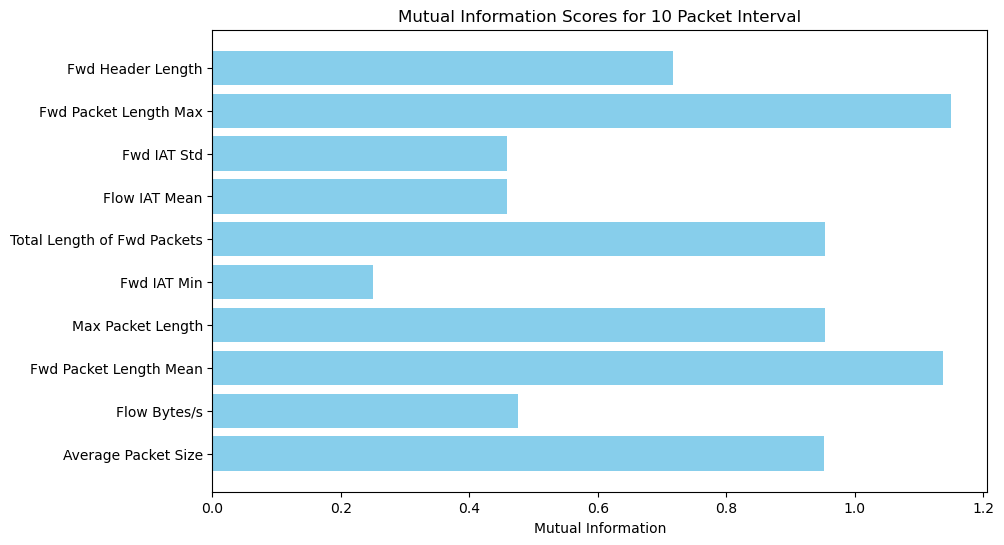

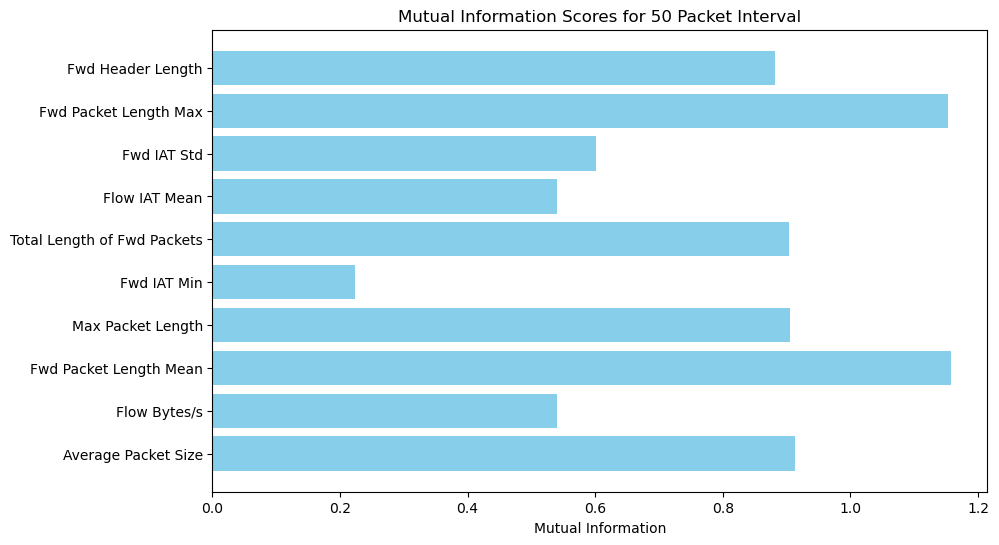

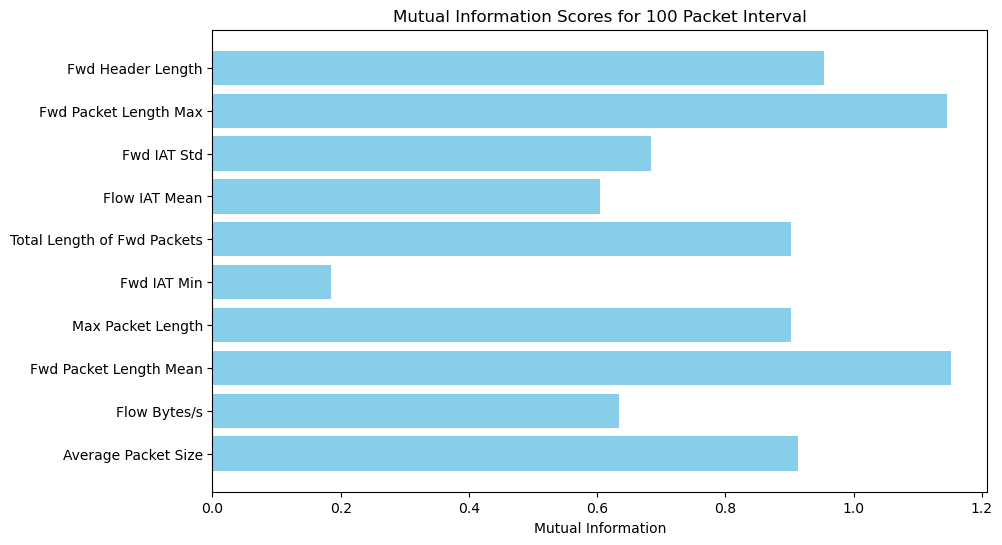

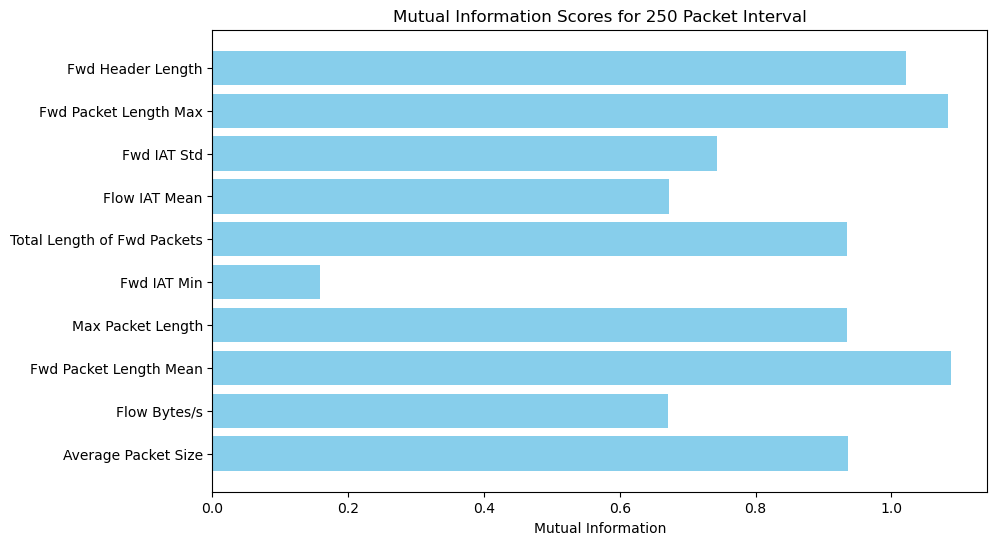

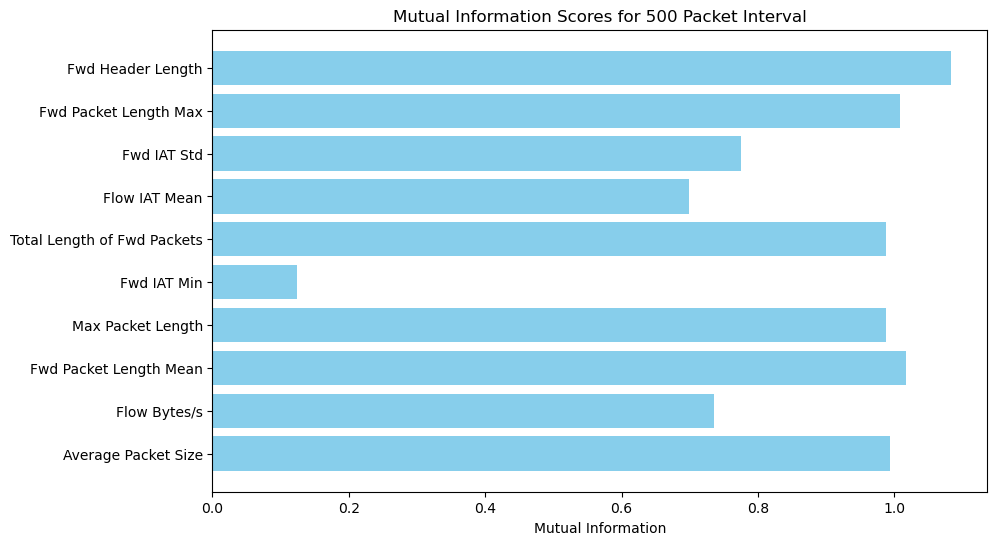

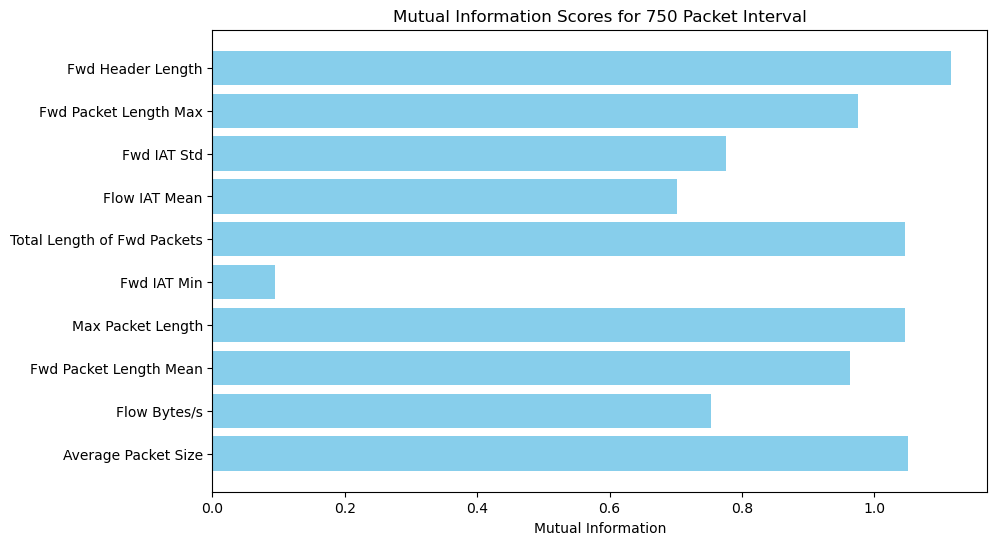

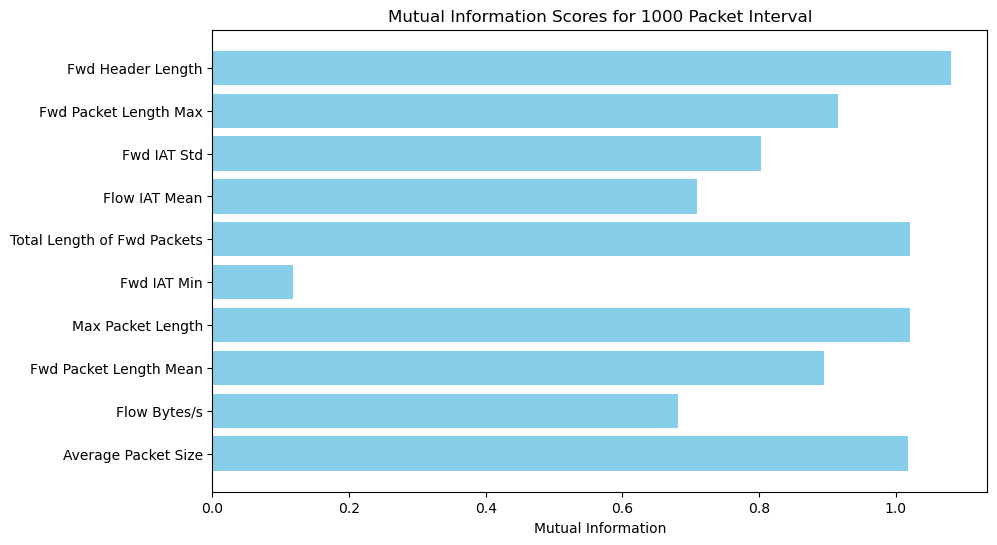

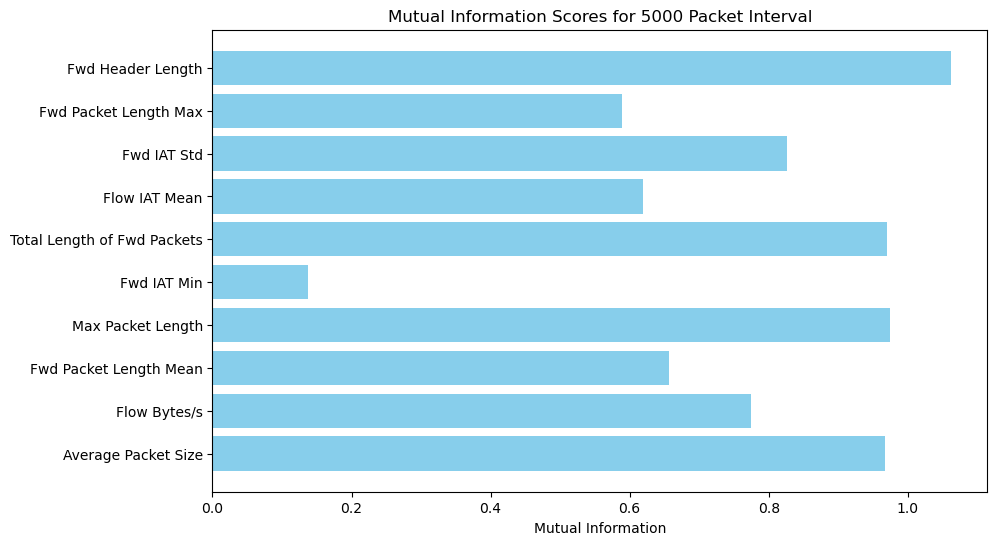

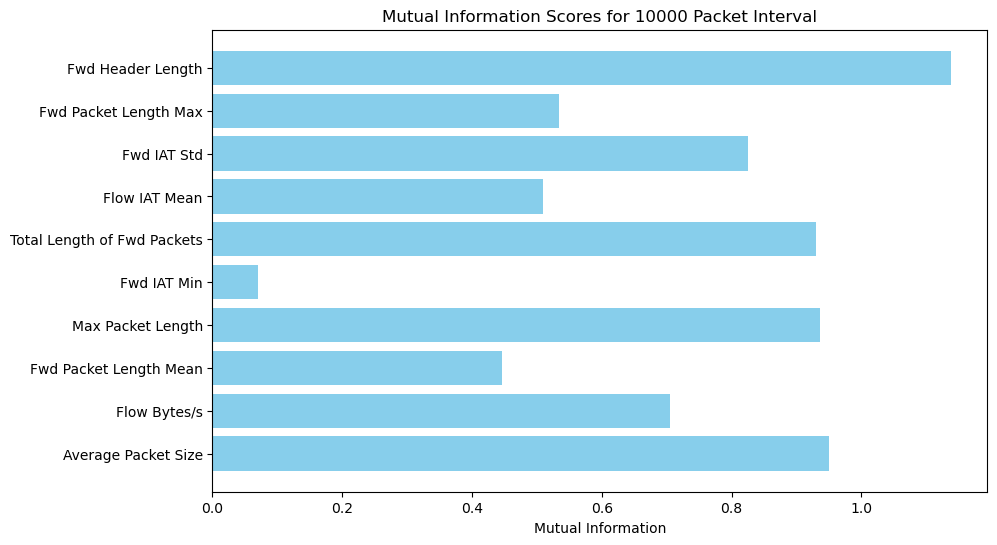

In [13]:
# Путь к папке с объединенными файлами
combined_path = "./combined/"

# Собираем данные по взаимной информации и пакетной выборке
mutual_info_data = []

for combined_file in os.listdir(combined_path):
    if combined_file.endswith(".csv"):
        # Чтение данных
        df = pd.read_csv(os.path.join(combined_path, combined_file))

        # Признаки (X) и целевая переменная (y)
        X = df.drop(columns=["Label"])
        y = df["Label"]

        # Расчет взаимной информации
        mutual_info = mutual_info_classif(X, y, random_state=0)

        # Извлечение размера пакетной выборки из названия файла
        packet_size = int(re.search(r"(\d+)_packets", combined_file).group(1))

        # Сохранение данных
        mutual_info_data.append((packet_size, X.columns, mutual_info))

# Сортировка по длине выборки пакетов
mutual_info_data.sort(key=lambda x: x[0])

# Визуализация взаимной информации
for packet_size, feature_names, mutual_info in mutual_info_data:
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, mutual_info, color="skyblue")
    plt.xlabel("Mutual Information")
    plt.title(f"Mutual Information Scores for {packet_size} Packet Interval")
    plt.show()

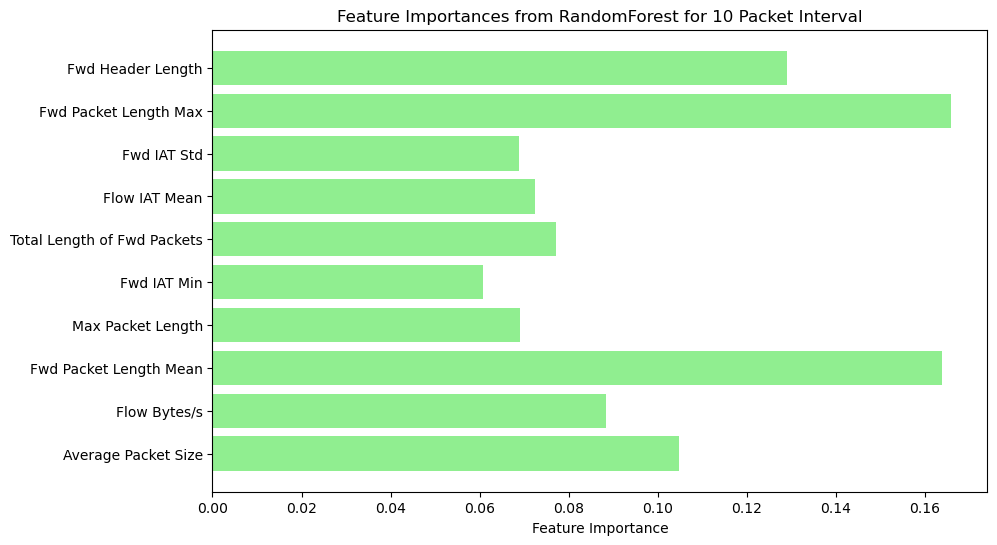

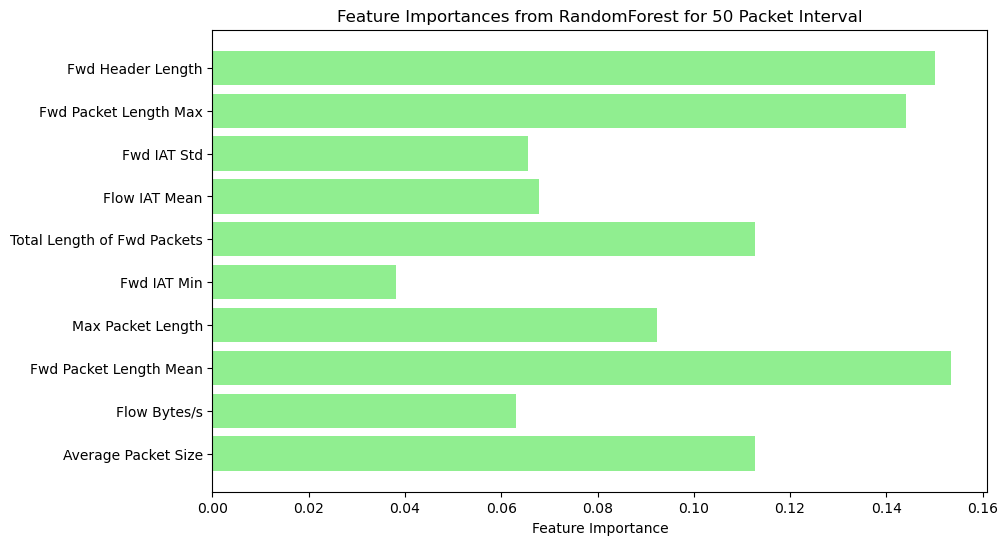

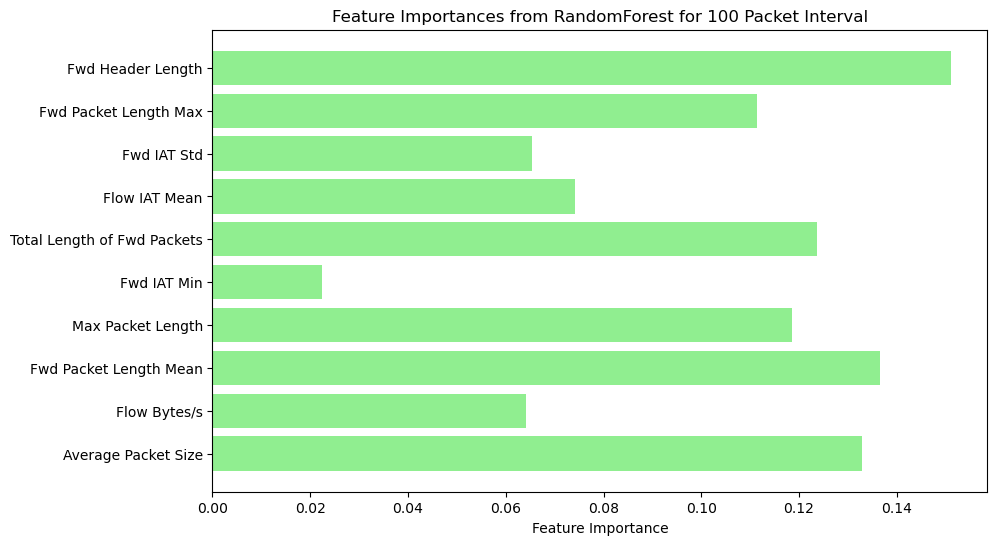

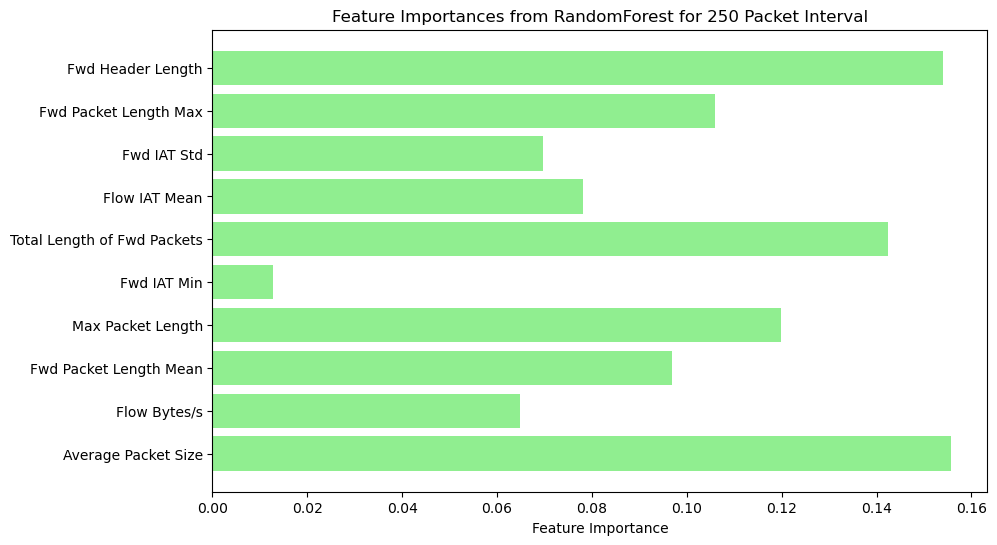

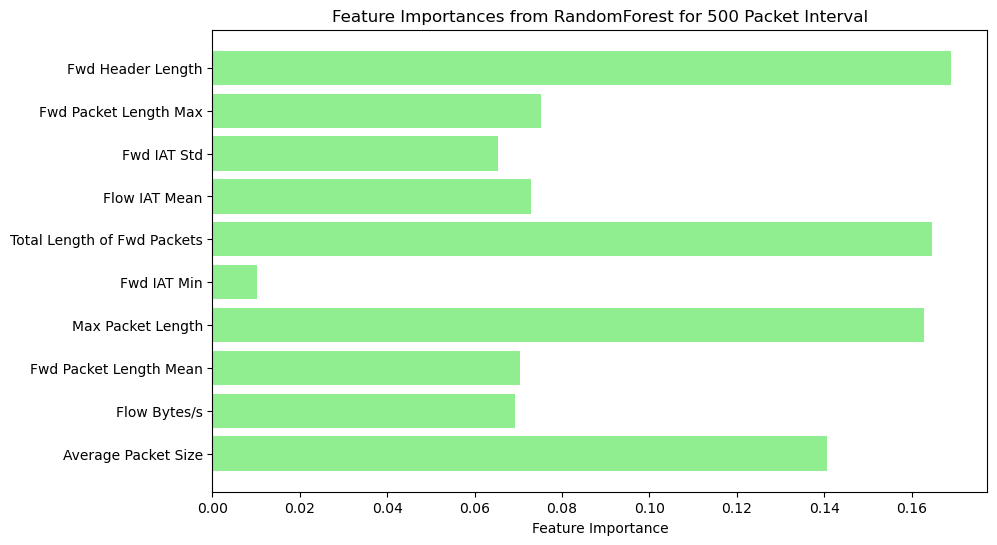

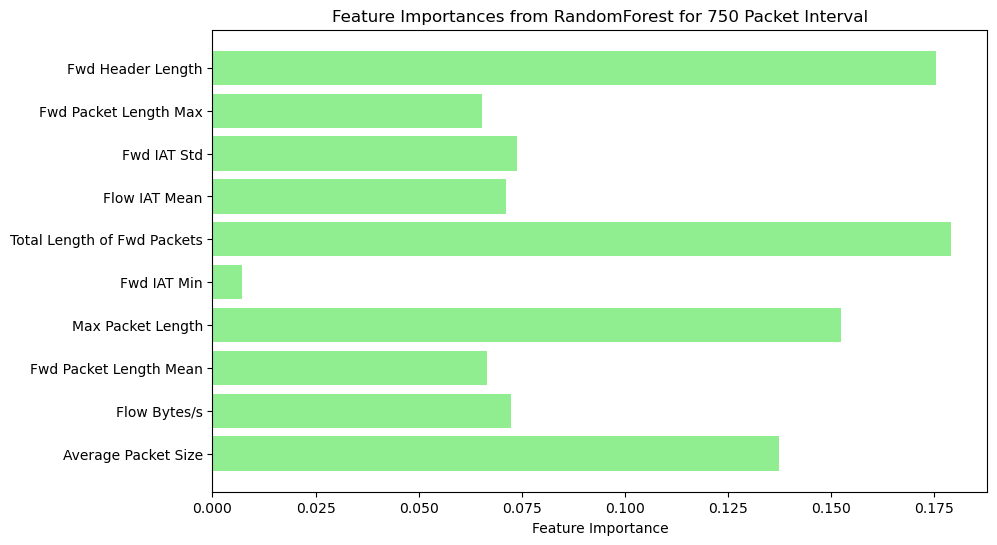

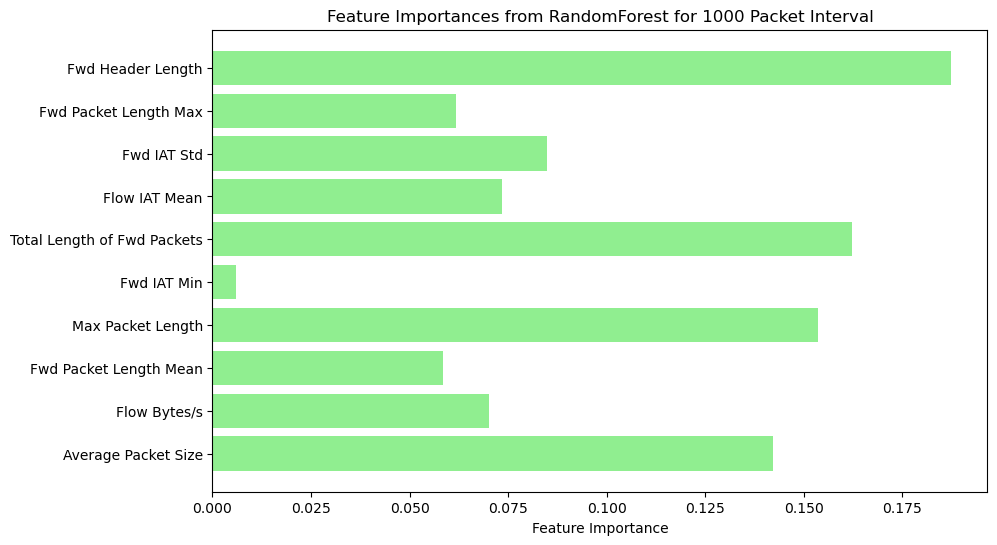

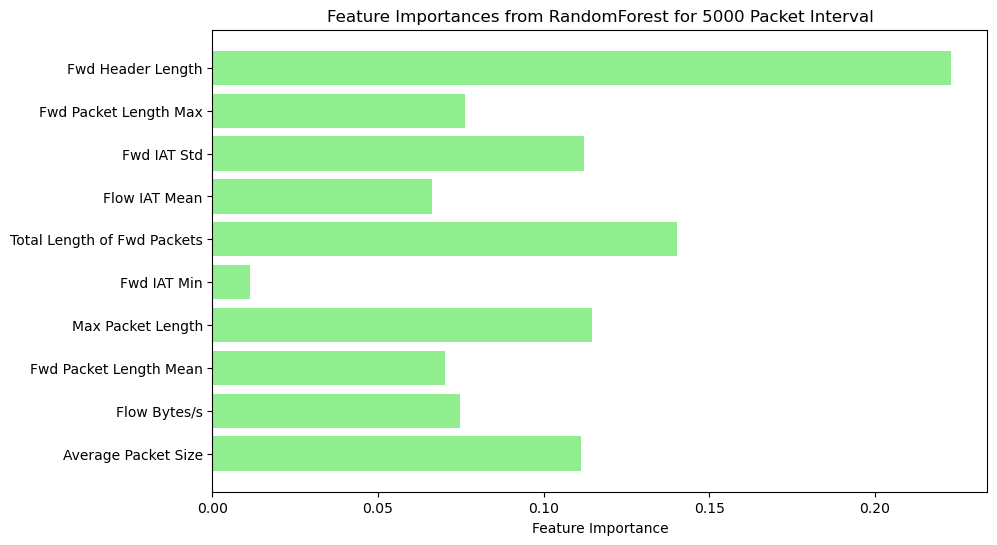

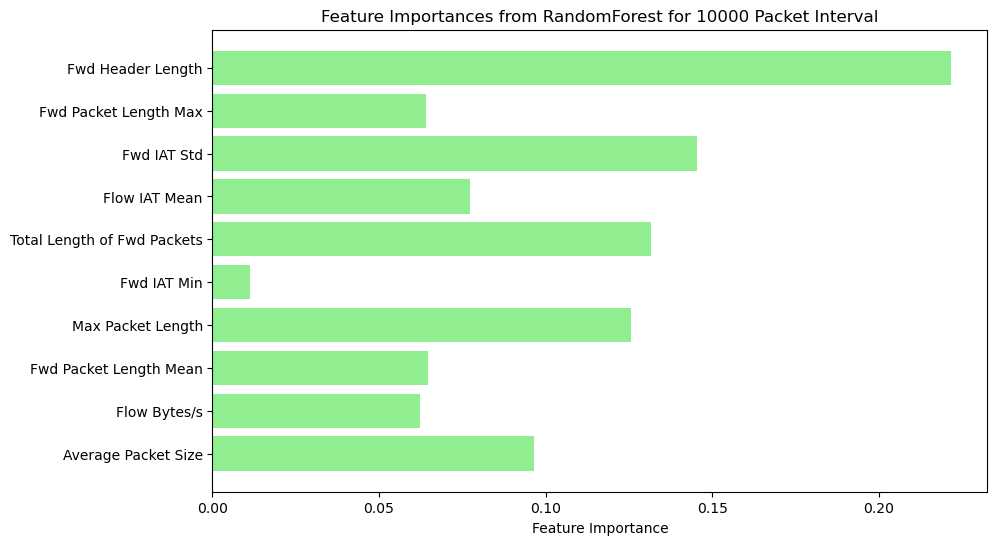

In [14]:
# Сбор данных по важности признаков и размеру выборки
feature_importances_data = []

for combined_file in os.listdir(combined_path):
    if combined_file.endswith(".csv"):
        # Чтение данных
        df = pd.read_csv(os.path.join(combined_path, combined_file))

        # Признаки (X) и целевая переменная (y)
        X = df.drop(columns=["Label"])
        y = df["Label"]

        # Обучение модели случайного леса
        model = RandomForestClassifier(random_state=0)
        model.fit(X, y)

        # Важности признаков
        importances = model.feature_importances_
        feature_names = X.columns

        # Извлечение размера выборки пакетов из названия файла
        packet_size = int(re.search(r"(\d+)_packets", combined_file).group(1))

        # Сохранение данных
        feature_importances_data.append((packet_size, feature_names, importances))

# Сортировка по длине выборки пакетов
feature_importances_data.sort(key=lambda x: x[0])

# Визуализация важности признаков
for packet_size, feature_names, importances in feature_importances_data:
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances, color="lightgreen")
    plt.xlabel("Feature Importance")
    plt.title(
        f"Feature Importances from RandomForest for {packet_size} Packet Interval"
    )
    plt.show()

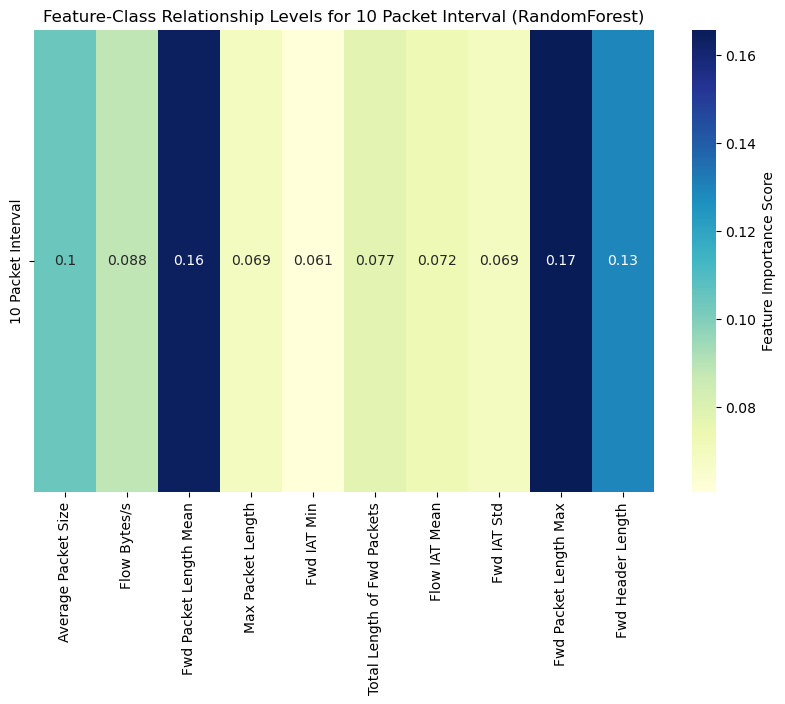

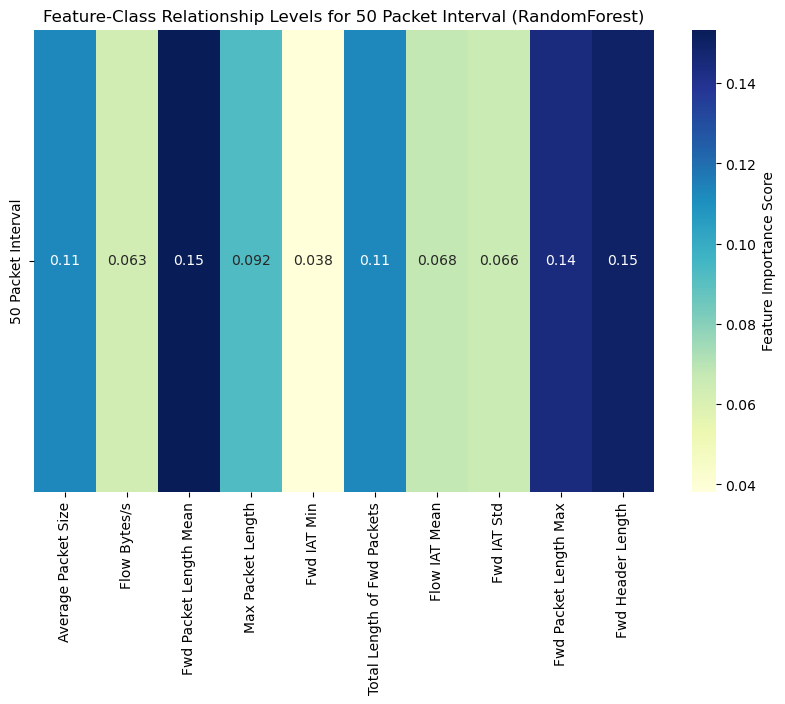

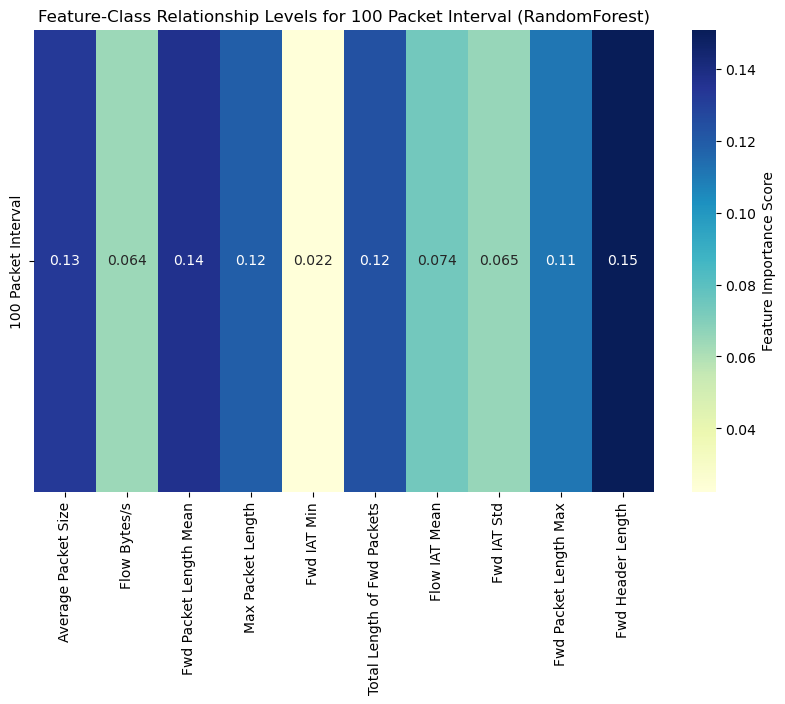

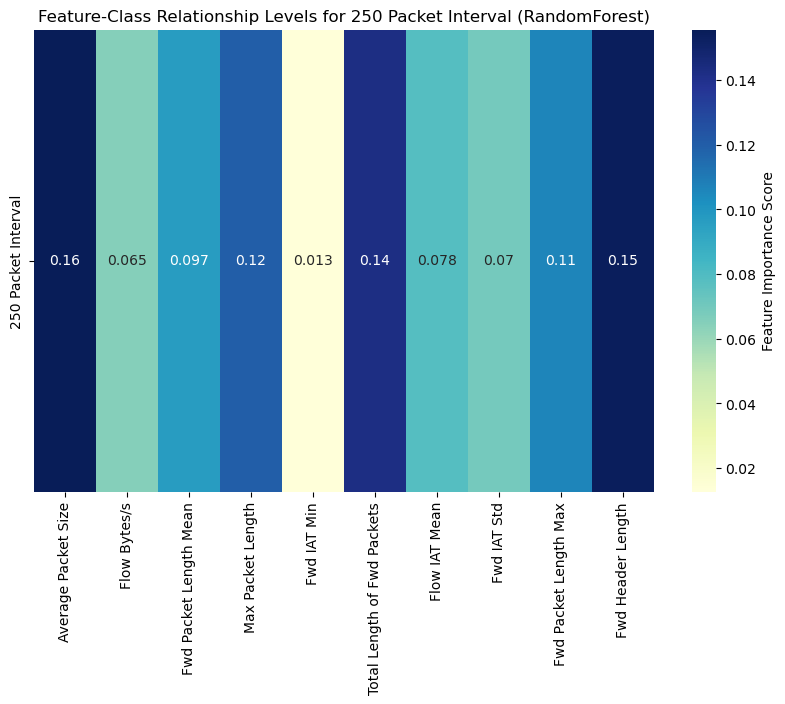

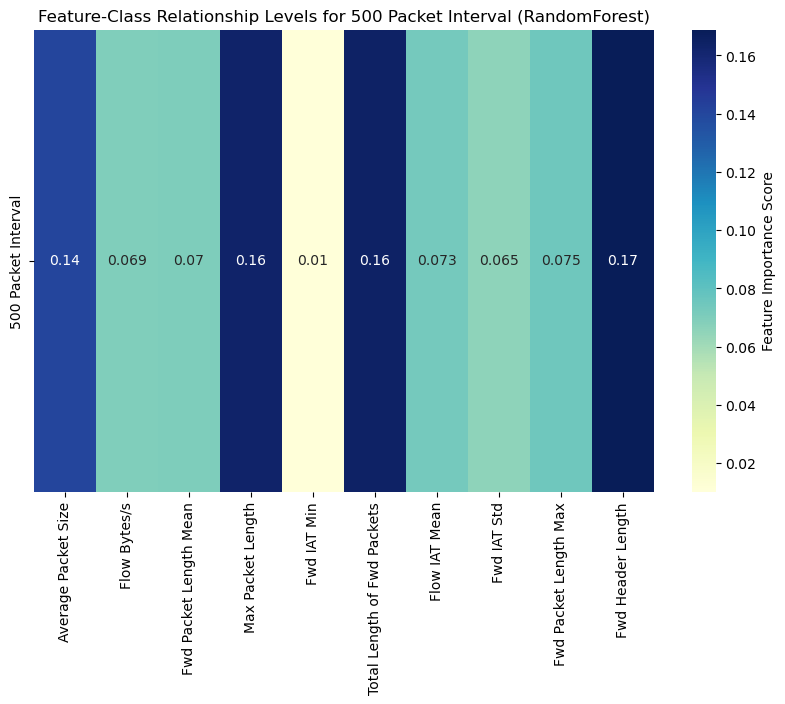

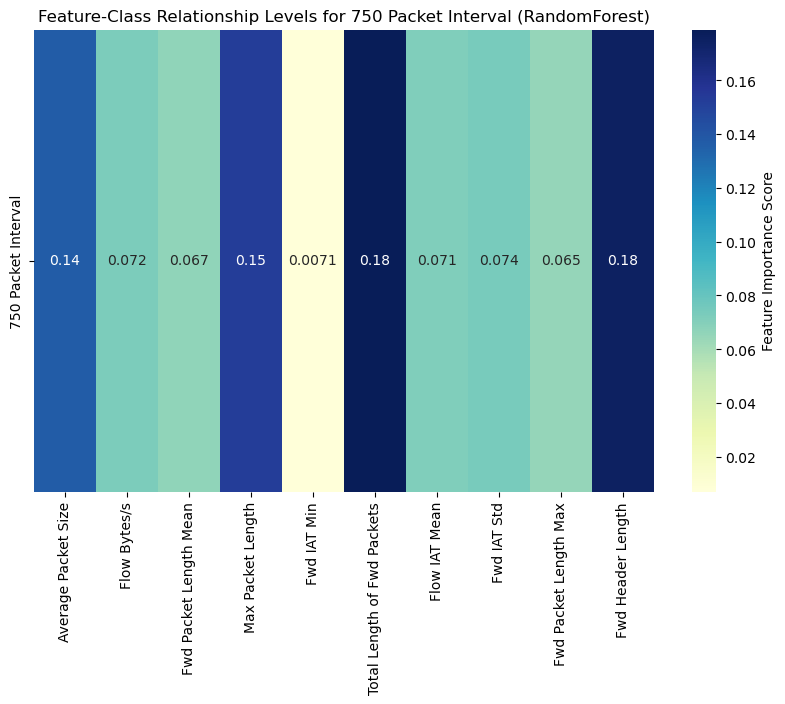

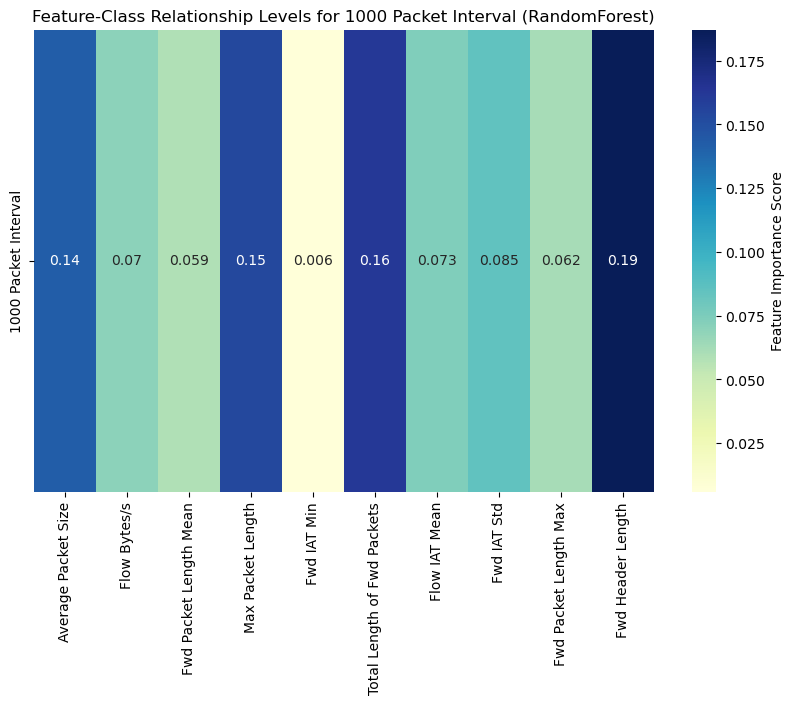

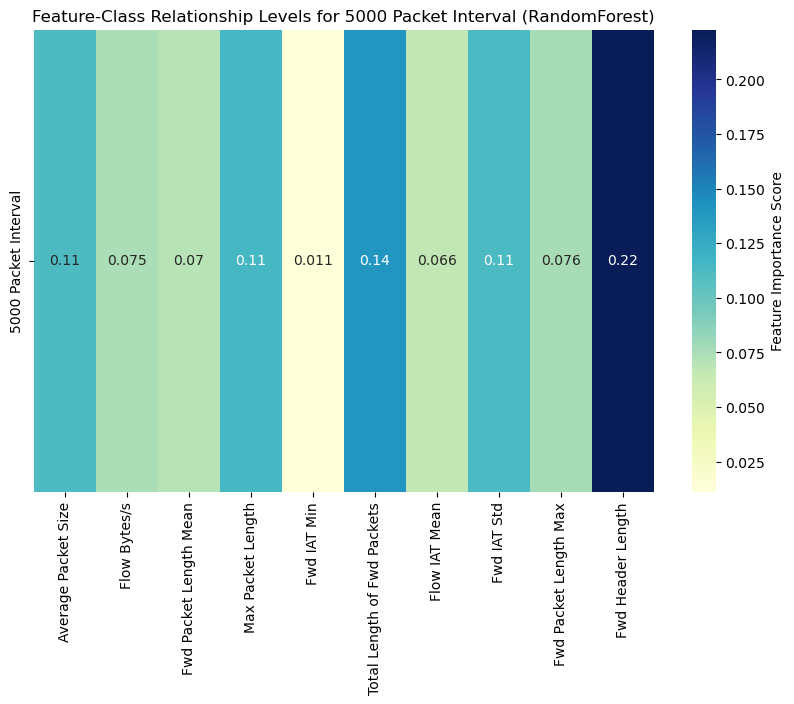

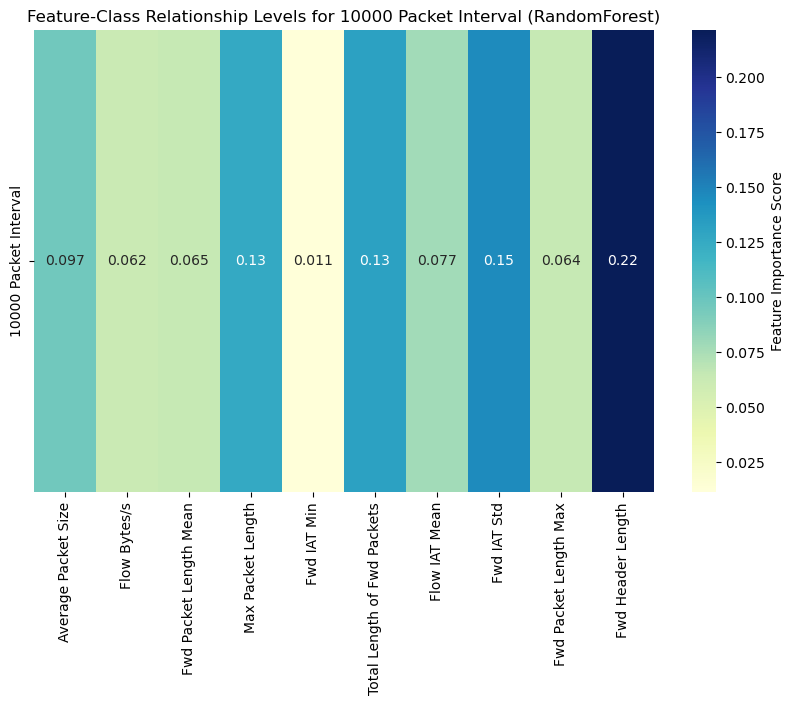

In [15]:
# Сбор данных по важности признаков для каждого размера выборки
feature_importances_data = []

for combined_file in os.listdir(combined_path):
    if combined_file.endswith(".csv"):
        # Чтение данных
        df = pd.read_csv(os.path.join(combined_path, combined_file))

        # Признаки (X) и целевая переменная (y)
        X = df.drop(columns=["Label"])
        y = df["Label"]

        # Обучение модели случайного леса
        model = RandomForestClassifier(random_state=0)
        model.fit(X, y)

        # Важности признаков
        importances = model.feature_importances_
        feature_names = X.columns

        # Извлечение размера выборки пакетов из названия файла
        packet_size = int(re.search(r"(\d+)_packets", combined_file).group(1))

        # Сохранение данных
        feature_importances_data.append((packet_size, feature_names, importances))

# Сортировка по длине выборки пакетов
feature_importances_data.sort(key=lambda x: x[0])

# Визуализация уровней связи в виде тепловой карты
for packet_size, feature_names, importances in feature_importances_data:
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        [importances],  # Преобразуем данные для визуализации в виде 2D массива
        annot=True,
        yticklabels=[f"{packet_size} Packet Interval"],
        xticklabels=feature_names,
        cmap="YlGnBu",
        cbar_kws={"label": "Feature Importance Score"},
    )
    plt.title(
        f"Feature-Class Relationship Levels for {packet_size} Packet Interval (RandomForest)"
    )
    plt.show()